# Method 8 - Best Ideas High Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Use Raw Weight

valid_data['adj_target'] = valid_data['target']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

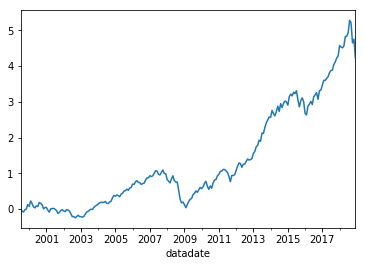

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.124186
2000-12-31   -0.072503
2001-12-31   -0.058342
2002-12-31   -0.194555
2003-12-31    0.400757
2004-12-31    0.245139
2005-12-31    0.163681
2006-12-31    0.166237
2007-12-31    0.061253
2008-12-31   -0.398077
2009-12-31    0.341628
2010-12-31    0.203344
2011-12-31    0.014423
2012-12-31    0.232115
2013-12-31    0.480683
2014-12-31    0.118509
2015-12-31    0.002323
2016-12-31    0.080265
2017-12-31    0.221219
2018-12-31   -0.011562
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     576.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.12e-118
Time:                        07:07:26   Log-Likelihood:                 672.31
No. Observations:                 234   AIC:                            -1335.
Df Residuals:                     229   BIC:                            -1317.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.574      0.000       0.002       0.005
mktrf          0.8950      0.026     34.710      0.000       0.844       0.946
me             0.3397      0.030     11.326      0.000       0.281       0.399
ia            -0.1727      0.046     -3.789      0.000      -0.263      -0.083
roe            0.0572      0.039      1.466      0.144      -0.020       0.134
==============================================================================
Omnibus:                       29.597   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.559
Skew:                          -0.631   Prob(JB):                     7.08e-14
Kurtosis:                       5.149   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     435.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          8.66e-106
Time:                        07:07:26   Log-Likelihood:                 672.31
No. Observations:                 234   AIC:                            -1335.
Df Residuals:                     229   BIC:                            -1317.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.649      0.000       0.002       0.005
mktrf          0.8950      0.037     24.270      0.000       0.823       0.967
me             0.3397      0.046      7.358      0.000       0.249       0.430
ia            -0.1727      0.071     -2.428      0.015      -0.312      -0.033
roe            0.0572      0.059      0.968      0.333      -0.059       0.173
==============================================================================
Omnibus:                       29.597   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.559
Skew:                          -0.631   Prob(JB):                     7.08e-14
Kurtosis:                       5.149   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     568.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          1.16e-117
Time:                        07:07:26   Log-Likelihood:                 672.31
No. Observations:                 234   AIC:                            -1335.
Df Residuals:                     229   BIC:                            -1317.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.224      0.001       0.001       0.005
mktrf          0.8950      0.028     31.622      0.000       0.840       0.950
me             0.3397      0.046      7.447      0.000       0.250       0.429
ia            -0.1727      0.065     -2.652      0.008      -0.300      -0.045
roe            0.0572      0.052      1.095      0.273      -0.045       0.160
==============================================================================
Omnibus:                       29.597   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.559
Skew:                          -0.631   Prob(JB):                     7.08e-14
Kurtosis:                       5.149   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     433.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.93e-114
Time:                        07:07:26   Log-Likelihood:                 666.24
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     228   BIC:                            -1300.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.937      0.000       0.002       0.006
mktrf          0.8806      0.027     33.140      0.000       0.828       0.933
smb            0.3109      0.035      8.868      0.000       0.242       0.380
hml           -0.0871      0.041     -2.106      0.036      -0.169      -0.006
rmw           -0.0575      0.047     -1.230      0.220      -0.150       0.035
cma           -0.0023      0.059     -0.038      0.970      -0.119       0.115
==============================================================================
Omnibus:                       23.007   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.683
Skew:                          -0.492   Prob(JB):                     7.29e-11
Kurtosis:                       4.955   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     517.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.00e-122
Time:                        07:07:26   Log-Likelihood:                 666.24
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     228   BIC:                            -1300.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.786      0.000       0.002       0.006
mktrf          0.8806      0.038     23.218      0.000       0.806       0.955
smb            0.3109      0.045      6.957      0.000       0.223       0.399
hml           -0.0871      0.058     -1.510      0.131      -0.200       0.026
rmw           -0.0575      0.067     -0.863      0.388      -0.188       0.073
cma           -0.0023      0.128     -0.018      0.986      -0.254       0.249
==============================================================================
Omnibus:                       23.007   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.683
Skew:                          -0.492   Prob(JB):                     7.29e-11
Kurtosis:                       4.955   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     657.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          2.97e-133
Time:                        07:07:26   Log-Likelihood:                 666.24
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     228   BIC:                            -1300.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      3.390      0.001       0.002       0.006
mktrf          0.8806      0.035     25.293      0.000       0.812       0.949
smb            0.3109      0.041      7.561      0.000       0.230       0.392
hml           -0.0871      0.062     -1.415      0.157      -0.208       0.033
rmw           -0.0575      0.063     -0.917      0.359      -0.180       0.065
cma           -0.0023      0.142     -0.016      0.987      -0.281       0.276
==============================================================================
Omnibus:                       23.007   Durbin-Watson:                   2.121
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.683
Skew:                          -0.492   Prob(JB):                     7.29e-11
Kurtosis:                       4.955   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     600.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.01e-120
Time:                        07:07:26   Log-Likelihood:                 676.76
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.267      0.001       0.001       0.005
mktrf          0.9522      0.023     40.879      0.000       0.906       0.998
smb            0.2717      0.029      9.343      0.000       0.214       0.329
hml           -0.0212      0.029     -0.734      0.464      -0.078       0.036
umd            0.1048      0.019      5.530      0.000       0.067       0.142
==============================================================================
Omnibus:                       30.872   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.189
Skew:                          -0.625   Prob(JB):                     9.46e-16
Kurtosis:                       5.353   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     887.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          4.47e-138
Time:                        07:07:26   Log-Likelihood:                 676.76
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      3.113      0.002       0.001       0.005
mktrf          0.9522      0.029     32.457      0.000       0.895       1.010
smb            0.2717      0.043      6.340      0.000       0.188       0.356
hml           -0.0212      0.039     -0.546      0.585      -0.097       0.055
umd            0.1048      0.022      4.861      0.000       0.063       0.147
==============================================================================
Omnibus:                       30.872   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.189
Skew:                          -0.625   Prob(JB):                     9.46e-16
Kurtosis:                       5.353   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     948.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.22e-141
Time:                        07:07:26   Log-Likelihood:                 676.76
No. Observations:                 234   AIC:                            -1344.
Df Residuals:                     229   BIC:                            -1326.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.001      2.975      0.003       0.001       0.005
mktrf          0.9522      0.026     36.514      0.000       0.901       1.003
smb            0.2717      0.034      7.920      0.000       0.204       0.339
hml           -0.0212      0.040     -0.533      0.594      -0.099       0.057
umd            0.1048      0.020      5.229      0.000       0.066       0.144
==============================================================================
Omnibus:                       30.872   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.189
Skew:                          -0.625   Prob(JB):                     9.46e-16
Kurtosis:                       5.353   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     255.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.37e-56
Time:                        07:07:26   Log-Likelihood:                 324.90
No. Observations:                 120   AIC:                            -639.8
Df Residuals:                     115   BIC:                            -625.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.002      1.593      0.114      -0.001       0.006
mktrf          0.9185      0.042     21.614      0.000       0.834       1.003
me             0.3616      0.042      8.616      0.000       0.278       0.445
ia            -0.1599      0.066     -2.433      0.016      -0.290      -0.030
roe            0.1214      0.058      2.088      0.039       0.006       0.237
==============================================================================
Omnibus:                       13.777   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.444
Skew:                          -0.591   Prob(JB):                     5.99e-05
Kurtosis:                       4.579   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     260.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.18e-56
Time:                        07:07:26   Log-Likelihood:                 324.90
No. Observations:                 120   AIC:                            -639.8
Df Residuals:                     115   BIC:                            -625.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.927      0.054   -4.26e-05       0.005
mktrf          0.9185      0.061     15.135      0.000       0.800       1.037
me             0.3616      0.061      5.947      0.000       0.242       0.481
ia            -0.1599      0.083     -1.920      0.055      -0.323       0.003
roe            0.1214      0.075      1.621      0.105      -0.025       0.268
==============================================================================
Omnibus:                       13.777   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.444
Skew:                          -0.591   Prob(JB):                     5.99e-05
Kurtosis:                       4.579   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     425.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.24e-68
Time:                        07:07:26   Log-Likelihood:                 324.90
No. Observations:                 120   AIC:                            -639.8
Df Residuals:                     115   BIC:                            -625.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.688      0.091      -0.000       0.005
mktrf          0.9185      0.043     21.489      0.000       0.835       1.002
me             0.3616      0.059      6.092      0.000       0.245       0.478
ia            -0.1599      0.074     -2.157      0.031      -0.305      -0.015
roe            0.1214      0.056      2.164      0.030       0.011       0.231
==============================================================================
Omnibus:                       13.777   Durbin-Watson:                   2.208
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.444
Skew:                          -0.591   Prob(JB):                     5.99e-05
Kurtosis:                       4.579   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     175.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.32e-52
Time:                        07:07:26   Log-Likelihood:                 317.35
No. Observations:                 120   AIC:                            -622.7
Df Residuals:                     114   BIC:                            -606.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.359      0.020       0.001       0.008
mktrf          0.8861      0.048     18.488      0.000       0.791       0.981
smb            0.3174      0.054      5.846      0.000       0.210       0.425
hml           -0.1009      0.067     -1.516      0.132      -0.233       0.031
rmw           -0.0386      0.078     -0.492      0.624      -0.194       0.117
cma            0.0639      0.086      0.743      0.459      -0.106       0.234
==============================================================================
Omnibus:                        7.582   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.695
Skew:                          -0.466   Prob(JB):                       0.0213
Kurtosis:                       3.818   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     214.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.29e-56
Time:                        07:07:26   Log-Likelihood:                 317.35
No. Observations:                 120   AIC:                            -622.7
Df Residuals:                     114   BIC:                            -606.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.441      0.015       0.001       0.007
mktrf          0.8861      0.075     11.880      0.000       0.740       1.032
smb            0.3174      0.063      5.031      0.000       0.194       0.441
hml           -0.1009      0.092     -1.095      0.273      -0.281       0.080
rmw           -0.0386      0.113     -0.341      0.733      -0.260       0.183
cma            0.0639      0.159      0.402      0.688      -0.248       0.375
==============================================================================
Omnibus:                        7.582   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.695
Skew:                          -0.466   Prob(JB):                       0.0213
Kurtosis:                       3.818   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     229.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.27e-58
Time:                        07:07:26   Log-Likelihood:                 317.35
No. Observations:                 120   AIC:                            -622.7
Df Residuals:                     114   BIC:                            -606.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.170      0.030       0.000       0.008
mktrf          0.8861      0.070     12.749      0.000       0.750       1.022
smb            0.3174      0.056      5.653      0.000       0.207       0.427
hml           -0.1009      0.100     -1.012      0.311      -0.296       0.094
rmw           -0.0386      0.113     -0.343      0.732      -0.259       0.182
cma            0.0639      0.171      0.372      0.710      -0.272       0.400
==============================================================================
Omnibus:                        7.582   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.695
Skew:                          -0.466   Prob(JB):                       0.0213
Kurtosis:                       3.818   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     256.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.74e-56
Time:                        07:07:26   Log-Likelihood:                 325.12
No. Observations:                 120   AIC:                            -640.2
Df Residuals:                     115   BIC:                            -626.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.406      0.018       0.001       0.007
mktrf          0.9746      0.037     26.080      0.000       0.901       1.049
smb            0.2577      0.043      6.057      0.000       0.173       0.342
hml           -0.0028      0.043     -0.065      0.948      -0.087       0.082
umd            0.1197      0.026      4.556      0.000       0.068       0.172
==============================================================================
Omnibus:                       20.708   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.855
Skew:                          -0.796   Prob(JB):                     4.45e-08
Kurtosis:                       5.058   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     609.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.14e-76
Time:                        07:07:26   Log-Likelihood:                 325.12
No. Observations:                 120   AIC:                            -640.2
Df Residuals:                     115   BIC:                            -626.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      2.493      0.013       0.001       0.007
mktrf          0.9746      0.046     21.407      0.000       0.885       1.064
smb            0.2577      0.062      4.158      0.000       0.136       0.379
hml           -0.0028      0.048     -0.058      0.954      -0.096       0.090
umd            0.1197      0.025      4.883      0.000       0.072       0.168
==============================================================================
Omnibus:                       20.708   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.855
Skew:                          -0.796   Prob(JB):                     4.45e-08
Kurtosis:                       5.058   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     820.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.55e-83
Time:                        07:07:26   Log-Likelihood:                 325.12
No. Observations:                 120   AIC:                            -640.2
Df Residuals:                     115   BIC:                            -626.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      2.491      0.013       0.001       0.007
mktrf          0.9746      0.036     26.747      0.000       0.903       1.046
smb            0.2577      0.049      5.247      0.000       0.161       0.354
hml           -0.0028      0.049     -0.057      0.955      -0.098       0.093
umd            0.1197      0.018      6.707      0.000       0.085       0.155
==============================================================================
Omnibus:                       20.708   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.855
Skew:                          -0.796   Prob(JB):                     4.45e-08
Kurtosis:                       5.058   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     414.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.11e-65
Time:                        07:07:26   Log-Likelihood:                 367.96
No. Observations:                 114   AIC:                            -725.9
Df Residuals:                     109   BIC:                            -712.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      4.414      0.000       0.002       0.006
mktrf          0.8882      0.029     30.794      0.000       0.831       0.945
me             0.2815      0.045      6.320      0.000       0.193       0.370
ia            -0.2743      0.062     -4.440      0.000      -0.397      -0.152
roe           -0.1443      0.054     -2.659      0.009      -0.252      -0.037
==============================================================================
Omnibus:                        0.440   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.802   Jarque-Bera (JB):                0.128
Skew:                           0.006   Prob(JB):                        0.938
Kurtosis:                       3.164   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     454.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.28e-67
Time:                        07:07:27   Log-Likelihood:                 367.96
No. Observations:                 114   AIC:                            -725.9
Df Residuals:                     109   BIC:                            -712.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      3.483      0.000       0.002       0.007
mktrf          0.8882      0.027     32.991      0.000       0.835       0.941
me             0.2815      0.038      7.327      0.000       0.206       0.357
ia            -0.2743      0.079     -3.459      0.001      -0.430      -0.119
roe           -0.1443      0.069     -2.093      0.036      -0.279      -0.009
==============================================================================
Omnibus:                        0.440   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.802   Jarque-Bera (JB):                0.128
Skew:                           0.006   Prob(JB):                        0.938
Kurtosis:                       3.164   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     809.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.67e-80
Time:                        07:07:27   Log-Likelihood:                 367.96
No. Observations:                 114   AIC:                            -725.9
Df Residuals:                     109   BIC:                            -712.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.001      3.041      0.002       0.002       0.007
mktrf          0.8882      0.023     38.177      0.000       0.843       0.934
me             0.2815      0.041      6.896      0.000       0.201       0.361
ia            -0.2743      0.086     -3.179      0.001      -0.443      -0.105
roe           -0.1443      0.068     -2.131      0.033      -0.277      -0.012
==============================================================================
Omnibus:                        0.440   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.802   Jarque-Bera (JB):                0.128
Skew:                           0.006   Prob(JB):                        0.938
Kurtosis:                       3.164   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     430.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-69
Time:                        07:07:27   Log-Likelihood:                 382.50
No. Observations:                 114   AIC:                            -753.0
Df Residuals:                     108   BIC:                            -736.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.918      0.000       0.002       0.005
mktrf          0.9040      0.024     37.157      0.000       0.856       0.952
smb            0.2627      0.039      6.651      0.000       0.184       0.341
hml           -0.0921      0.050     -1.827      0.070      -0.192       0.008
rmw           -0.2454      0.062     -3.979      0.000      -0.368      -0.123
cma           -0.2228      0.078     -2.846      0.005      -0.378      -0.068
==============================================================================
Omnibus:                        0.346   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.841   Jarque-Bera (JB):                0.252
Skew:                          -0.115   Prob(JB):                        0.882
Kurtosis:                       2.981   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     335.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.32e-64
Time:                        07:07:27   Log-Likelihood:                 382.50
No. Observations:                 114   AIC:                            -753.0
Df Residuals:                     108   BIC:                            -736.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.434      0.001       0.001       0.005
mktrf          0.9040      0.024     37.104      0.000       0.856       0.952
smb            0.2627      0.027      9.841      0.000       0.210       0.315
hml           -0.0921      0.045     -2.044      0.041      -0.180      -0.004
rmw           -0.2454      0.045     -5.478      0.000      -0.333      -0.158
cma           -0.2228      0.094     -2.367      0.018      -0.407      -0.038
==============================================================================
Omnibus:                        0.346   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.841   Jarque-Bera (JB):                0.252
Skew:                          -0.115   Prob(JB):                        0.882
Kurtosis:                       2.981   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     335.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.92e-64
Time:                        07:07:27   Log-Likelihood:                 382.50
No. Observations:                 114   AIC:                            -753.0
Df Residuals:                     108   BIC:                            -736.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      2.879      0.004       0.001       0.006
mktrf          0.9040      0.024     36.946      0.000       0.856       0.952
smb            0.2627      0.028      9.311      0.000       0.207       0.318
hml           -0.0921      0.040     -2.312      0.021      -0.170      -0.014
rmw           -0.2454      0.046     -5.368      0.000      -0.335      -0.156
cma           -0.2228      0.081     -2.741      0.006      -0.382      -0.064
==============================================================================
Omnibus:                        0.346   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.841   Jarque-Bera (JB):                0.252
Skew:                          -0.115   Prob(JB):                        0.882
Kurtosis:                       2.981   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     432.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.58e-66
Time:                        07:07:27   Log-Likelihood:                 370.30
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     109   BIC:                            -716.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.494      0.014       0.000       0.004
mktrf          0.9360      0.027     34.951      0.000       0.883       0.989
smb            0.3124      0.042      7.481      0.000       0.230       0.395
hml           -0.1104      0.043     -2.568      0.012      -0.196      -0.025
umd            0.0441      0.032      1.360      0.177      -0.020       0.108
==============================================================================
Omnibus:                        1.607   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.108
Skew:                          -0.195   Prob(JB):                        0.575
Kurtosis:                       3.285   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     682.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.84e-76
Time:                        07:07:27   Log-Likelihood:                 370.30
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     109   BIC:                            -716.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.283      0.022       0.000       0.004
mktrf          0.9360      0.018     52.160      0.000       0.901       0.971
smb            0.3124      0.039      8.092      0.000       0.237       0.388
hml           -0.1104      0.034     -3.283      0.001      -0.176      -0.044
umd            0.0441      0.032      1.374      0.170      -0.019       0.107
==============================================================================
Omnibus:                        1.607   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.108
Skew:                          -0.195   Prob(JB):                        0.575
Kurtosis:                       3.285   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     971.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.04e-84
Time:                        07:07:27   Log-Likelihood:                 370.30
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     109   BIC:                            -716.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.021      0.043    7.18e-05       0.005
mktrf          0.9360      0.017     55.255      0.000       0.903       0.969
smb            0.3124      0.044      7.096      0.000       0.226       0.399
hml           -0.1104      0.031     -3.616      0.000      -0.170      -0.051
umd            0.0441      0.034      1.288      0.198      -0.023       0.111
==============================================================================
Omnibus:                        1.607   Durbin-Watson:                   1.804
Prob(Omnibus):                  0.448   Jarque-Bera (JB):                1.108
Skew:                          -0.195   Prob(JB):                        0.575
Kurtosis:                       3.285   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""